<h3> Metody do przewidywania tagów POS - zestawienie

In [1]:
from nltk.corpus import treebank 

train_set =  treebank.tagged_sents()[:3000]
test_set =   treebank.tagged_sents()[3000:]

<h4> HMM

In [4]:
#HMM Hidden Markov Models, tradycyjny ukryty model Markowa, stan następny jest generowany na podstawie stanu poprzedniego
from nltk.tag import hmm

HMM_model = hmm.HiddenMarkovModelTrainer() 
HMM_tagger = HMM_model.train_supervised(train_set)
print("Na zbiorze testowym:", HMM_tagger.accuracy(test_set))

Na zbiorze testowym: 0.36844377293330455


<h4> TnT

In [5]:
#TnT = Trigrams'n'Tags, jest także metodą typu HMM, jednak tym razem stan następny generowany jest na podstawie [[dwoch]] poprzednich stanow. Ponadto wyposazony jest w metody wygładzania (smoothing), nieznane slowa obsługiwane są przy pomocy drzew sufiksowych 
from nltk.tag import tnt

TnT_model = tnt.TnT()
TnT_model.train(train_set)
print("Na zbiorze testowym: ", TnT_model.accuracy(test_set))

Na zbiorze testowym:  0.875545003237643


<h4> CRF

In [2]:
#CRF = Conditional Random Fields, używa dodatkowych funkcji modyfikujacych prawdopodobieństwa stanów, optymalne rozwiązanie uzyskuje się przez zastosowanie algorytmu podobnego do algorytmu Viterbiego
from nltk.tag import CRFTagger

CRF_model = CRFTagger() #moze byc potrzebne pip install python-crfsuite
CRF_model.train(train_set, 'crf_tagger_model')
print("Na zbiorze testowym:",CRF_model.accuracy(test_set))

Na zbiorze testowym: 0.9474638463198791


<h4> Sieci neuronowe

In [3]:
#Rozwiązanie przy pomocy sieci neuronowych, inna idea niz w przypadku trzech poprzednich metod, o sieciach neuronowych jeszcze będzie w przyszlosci :)
from nltk.tag.perceptron import PerceptronTagger

PER_model = PerceptronTagger(load = False)
PER_model.train(train_set)
print("Na zbiorze testowym:",PER_model.accuracy(test_set))

Na zbiorze testowym: 0.9587308439456076


<h3> Zastosowanie Twierdzenia Bayesa do klasyfikacji recenzji filmowych


Ogólny schemat klasyfikacji:

- mamy pewne dane (zbiór tekstów) oraz kategorie do których należą
- dzielimy dane na dwie części: zbiór treningowy i zbiór testowy
- uczymy model na zbiorze treningowym (model wie który tekst należy do której kategorii)
- testujemy model na zbiore testowym (model nie wie do jakiej kategorii należą nowe teksty - ma to przewidzieć)
- porównujemy zdolności predykacyjne modelu z tym jak jest (np przy użyciu parametru dokładności).

In [4]:
import nltk

In [110]:
from nltk.corpus import movie_reviews #korpus z recenzjami - 1000 poztytywnych i 1000 negatywnych

In [111]:
movie_reviews.categories()

['neg', 'pos']

In [112]:
print(movie_reviews.fileids()[990:1010]) #1000 recenzji pozytywnych i 1000 recenzji negatywnych

['neg/cv990_12443.txt', 'neg/cv991_19973.txt', 'neg/cv992_12806.txt', 'neg/cv993_29565.txt', 'neg/cv994_13229.txt', 'neg/cv995_23113.txt', 'neg/cv996_12447.txt', 'neg/cv997_5152.txt', 'neg/cv998_15691.txt', 'neg/cv999_14636.txt', 'pos/cv000_29590.txt', 'pos/cv001_18431.txt', 'pos/cv002_15918.txt', 'pos/cv003_11664.txt', 'pos/cv004_11636.txt', 'pos/cv005_29443.txt', 'pos/cv006_15448.txt', 'pos/cv007_4968.txt', 'pos/cv008_29435.txt', 'pos/cv009_29592.txt']


In [113]:
documents = [] #tworze pustą liste, bede tu zapisywal slowa z kolejnych recenzji oraz kategorię do jakiej ta recenzja nalezy

for category in movie_reviews.categories(): #dla kazdej z kategorii (pos/neg)
    for fileid in movie_reviews.fileids(category): #dla wszytkich recenzji z danej kategorii
        documents.append((list(movie_reviews.words(fileid)), category)) #dodaj element typu ([ slowa z recenzji], 'pos/neg')

In [114]:
print(documents[0]) #zobaczmy jak wyglada pierwsza recenzja zapisana do documents w tym formacie                 

(['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', 'what', "'", 's', 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '"', 'sorta', '"', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind', '-', 'fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')', ',', 'but', 'there', 'are', 'good', 'and', 'b

In [115]:
import random #biblioteka do operacji na liczbach losowych czy tasowania danych

random.shuffle(documents) #tasuje kolejnosc w liscie documents, bo poki co pierwsze 1000 to neg, a kolejny 1000 to pos, a chce miec losowe ulozenie recenzji

In [116]:
all_words = [] #tu będą wszystkie slowa występujące we wszystkich recenzjach

for w in movie_reviews.words():  #dla wszystkich slow ze wszystkich dokumentow korpusu movie_reviews
    all_words.append(w.lower())  #dodaje do listy all_words slowa zapisane z malej litery

In [117]:
all_words = nltk.FreqDist(all_words) #liczę częstosci slow i nadpisuje zmienną all_words

In [118]:
all_words.most_common(5) #5 najpopularniejszych slow

[(',', 77717), ('the', 76529), ('.', 65876), ('a', 38106), ('and', 35576)]

In [119]:
all_words["stupid"] #ile razy wystąpilo slowo stupid

253

In [120]:
all_words["interesting"] 

638

In [121]:
all_words["boring"]

270

In [17]:
len(all_words) #ile wystapilo wszystkich slow

39768

In [122]:
word_features = [x[0] for x in all_words.most_common(3000)] #do zmiennej word_features zapisuje pierwsze 3000 najczęstszych slow

In [123]:
#Tworze funkcje, ktorej argumentami będzie lista wyrazow, a ktora będzie wywolywana dla kolejnych recenzji, będe sprawdzal czy występują w niej slowa z word_features

def find_features(document): #przez document rozumiemy tutaj lista wyrazow
    words = set(document)    #patrze na unikatowe slowa
    features = {}            #tworzę pusty slownik
    for w in word_features: #word_features zdefiniowane wyzej [lista 3000 najczęstych slow we wszystkich recenzjach]
        features[w] = (w in words) #True or False, dla kazdego slowa z word_features w zaleznosci czy jest czy nie w dokumencie
    return features

In [124]:
#Przykładowe wywołanie funkcji 
ex_r = movie_reviews.words('neg/cv000_29416.txt') #przykladowa recenzja

print(find_features(ex_r)['plot']) #czy slowo 'plot' wsytapilo w tej recenzji?
print(find_features(ex_r)['funny']) #czy slowo 'funny' wystapilo w tej recenzji?

True
False


In [125]:
featuresets = [(find_features(rev),category) for (rev,category) in documents] #zapisuje liste krotek (slownik jak wyzej, pos/neg)

In [128]:
print(featuresets[0])

({',': True, 'the': True, '.': True, 'a': True, 'and': True, 'of': True, 'to': True, "'": True, 'is': True, 'in': True, 's': True, '"': True, 'it': True, 'that': True, '-': False, ')': True, '(': True, 'as': True, 'with': True, 'for': True, 'his': True, 'this': True, 'film': True, 'i': True, 'he': True, 'but': False, 'on': True, 'are': False, 't': False, 'by': True, 'be': True, 'one': True, 'movie': True, 'an': True, 'who': True, 'not': True, 'you': True, 'from': True, 'at': True, 'was': True, 'have': True, 'they': False, 'has': True, 'her': False, 'all': True, '?': False, 'there': True, 'like': False, 'so': True, 'out': False, 'about': False, 'up': False, 'more': False, 'what': True, 'when': False, 'which': False, 'or': False, 'she': True, 'their': False, ':': False, 'some': False, 'just': True, 'can': False, 'if': True, 'we': False, 'him': True, 'into': False, 'even': False, 'only': True, 'than': False, 'no': False, 'good': True, 'time': True, 'most': True, 'its': False, 'will': True

In [35]:
training_set = featuresets[:1900] #jako zbior treningowy biorę pierwsze 1900 recenzji
testing_set = featuresets[1900:]  #jako zbior tetowy biorę pozostałe recenzje

In [36]:
#wykonuje algorytm Naive Bayes na zbiorze treningowym

classifier = nltk.NaiveBayesClassifier.train(training_set)

In [37]:
#testuje model na zbiorze testowym

print("Dokładność metody Naive Bayes do problemu klasfyikacji na zbiorze testowym wynosi:", (nltk.classify.accuracy(classifier,testing_set))*100)

Dokładność metody Naive Bayes do problemu klasfyikacji na zbiorze testowym wynosi: 81.0


In [38]:
classifier.show_most_informative_features(15) #jakie bylo 15 najbardziej rozstrzygających slow

Most Informative Features
             outstanding = True              pos : neg    =     11.2 : 1.0
                   mulan = True              pos : neg    =      8.4 : 1.0
                   damon = True              pos : neg    =      8.2 : 1.0
                  finest = True              pos : neg    =      7.7 : 1.0
              schumacher = True              neg : pos    =      7.4 : 1.0
                  seagal = True              neg : pos    =      7.4 : 1.0
             wonderfully = True              pos : neg    =      7.0 : 1.0
                 idiotic = True              neg : pos    =      7.0 : 1.0
                   inept = True              neg : pos    =      6.4 : 1.0
                religion = True              pos : neg    =      5.9 : 1.0
             beautifully = True              pos : neg    =      5.8 : 1.0
                   flynt = True              pos : neg    =      5.7 : 1.0
                    jedi = True              pos : neg    =      5.3 : 1.0

In [86]:
from sklearn.metrics import confusion_matrix

y_true = [label for (_, label) in testing_set]
y_pred = [classifier.classify(txt) for (txt, _) in testing_set]  # Przewidywane etykiety
mat = confusion_matrix(y_true, y_pred)

print(mat)

[[44  5]
 [14 37]]


In [79]:
(44+37)/(44+37+5+14)

0.81

<h4> Zadanie1: Czy fakt, że nie oczyściliśmy danych ze stopwords czy znaków interpunkcyjncyh znacząco wpłynął na pogorszenie predykcji? Odpowiedź uzasadnij (bez obliczeń, chodzi o 2 zdania komentarza).

<h4> Zadanie2: Powtórz 20 razy predykcję za pomocą metody Naive Bayes za każdym razem tasując listę documents (po co?). Zapisz do listy dokładności uzyskane za każdym razem. Wyznacz średnią dokładność i odchylenie standardowe z tych dokładności (wcześniej przerób listę na obiekt typu array). Narysuj histogram dokładności.

<h4> Zadanie3: Wyjaśnij czemu istotnym jest aby grupy tekstów reprezentujących klasy były w miarę równoliczne. Zbuduj model NaiveBayes, gdzie jako zbiór treningowy wybierz 900 recenzji pozytywnych i 100 negatywnych. Następnie zabadaj jak model sprawdza się na 100 pozostałych recenzjach pozytywnych a jak na 100 negatywnych (innych niż przy trenowaniu modelu). Skomentuj otrzymane wyniki.

<h4> Zadanie4: Zbuduj model do predykcji wiadomości SPAM/HAM. W tym celu użyj pliku  spam_ham.txt . Każda wiadomość opatrzona jest odpowiednim tagiem na początku kolejnego wiersza. Sprawdź ile w pliku znajduje się wiadomości typu SPAM i HAM. Uwzględnij uwagę z poprzedniego zadania.

Można zastosować też np. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html 

Warto przejrzeć: https://poleval.pl/

<h4> Zadanie5: Przeanalizuj dane allegro-reviews za pomocą modelu NaiveBayes. 
    
- Zbuduj model w którym rozważysz tylko recenzje z ocenami 5. i 1.
- Zbuduj model dla pełnych danych.
- Dokonaj modyfikacji, które poprawią te modele.

Uwagi:
- dane są już podzielone na zbiór treningowy i testowy
- dane nie są zbilasnowane, warto coś z tym zrobić
- warto ograniczyć liczbę słów, może jakaś lemmatyzacja?

https://huggingface.co/PL-MTEB

In [63]:
from datasets import load_dataset

ds = load_dataset("PL-MTEB/allegro-reviews")

  0%|          | 0/3 [00:00<?, ?it/s]

In [64]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9577
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1002
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1006
    })
})

In [66]:
train_data = ds["train"]
test_data = ds["test"]

In [67]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 9577
})

In [68]:
print(train_data[0]["text"]) 

Jako do ceny dobra. Przyssawka mogłaby być lepsza. Po 2 miesiącach użytkowania musiałem nóżkę z przyssawką rozkręcić i przyssawkę podkleić bo guma zaczęła pękać od strony mocowania do uchwytu (uchwyt zaczął się po prostu trząść bo zrobił się luz).  Mechanizm mocowania telefonu póki co (3 miesiące użytkowania) działa bez zarzutu. 


In [69]:
X_train = [ex["text"] for ex in train_data]
y_train = [ex["label"] for ex in train_data]

<h3> Serializacja (zapisywanie obiektu)


In [39]:
import pickle

t = [1,2,3,4,5]

#zapisywanie listy [jako obiektu!!!] do pliku 
save_list = open("my_list.pickle","wb") #w-write, b -bity
pickle.dump(t, save_list)
save_list.close()

In [40]:
#otwieranie
f = open("my_list.pickle","rb")
moja_lista = pickle.load(f) 
f.close()

In [41]:
print(moja_lista)

[1, 2, 3, 4, 5]


<h3> Uzupełnienie: Elementy statystyki i prezentacji danych

In [42]:
import numpy as np #biblioteka obiektow typu array i pozwalająca przeprowadzic operacje na nich

x = np.array([1,2,5,6,2,2,4,1,5,5,3,3,4,5,6]) #nowy typ danych, cos jak lista ale ma nowe metody, będzie jeszcze o tym w przyszlosci

In [43]:
type(x) #jaki typ

numpy.ndarray

In [44]:
x[-1] #ostatni element

6

In [45]:
x[0:4] #elementy 0,1,2,3

array([1, 2, 5, 6])

In [46]:
np.mean(x) #średnia

3.6

In [47]:
np.median(x) #mediana

4.0

In [48]:
np.sum(x)  #suma elementow

54

<h4> Porównanie obiektów typu listy i array


In [49]:
x = [1,2,3]
y = [4,5,6]

print(x+y)
print(3*x)

[1, 2, 3, 4, 5, 6]
[1, 2, 3, 1, 2, 3, 1, 2, 3]


In [50]:
x = np.array([1,2,3])
y = np.array([4,5,6])

print(x+y)
print(3*x)

[5 7 9]
[3 6 9]


In [51]:
#Z obiektem typu array moge zrobic cos czego z listą absolutnie mi nie wolno

x = np.array([1,2,3,4,5])
y = x**2 + np.sin(x)
print(y)

[ 1.84147098  4.90929743  9.14112001 15.2431975  24.04107573]


<h4> Rysowanie wykresów


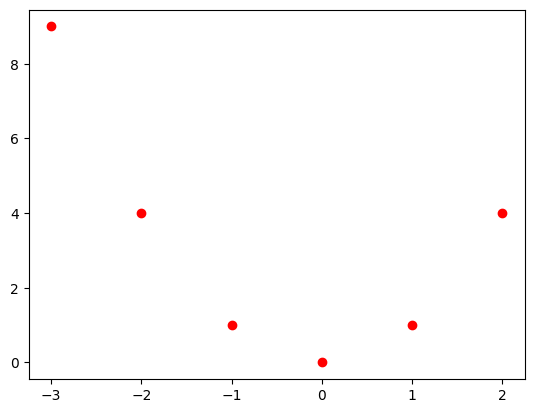

In [52]:
import matplotlib.pyplot as plt #biblioteka do rysowania wykresow

a = np.array([-3,-2,-1,0,1,2])
b = a**2

#Rysowanie
plt.scatter(a,b, c = "red") #to samo co wyzej, tyle ze tym razem nie łączy punktow
plt.show()

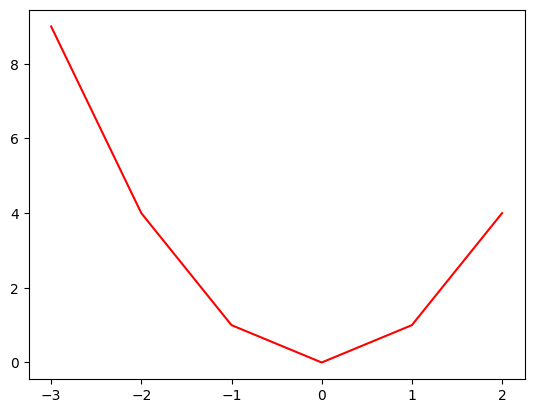

In [53]:
plt.plot(a,b, c = "red") #to samo co wyzej, tyle ze tym razem łączy punkty
plt.show()

In [54]:
x =  np.random.rand(1000) #generuje 1000 liczb z rozkładu jednostajnego
y =  np.random.randn(1000) #generuje 1000 liczb z rozkładu normalnego (Gaussa)

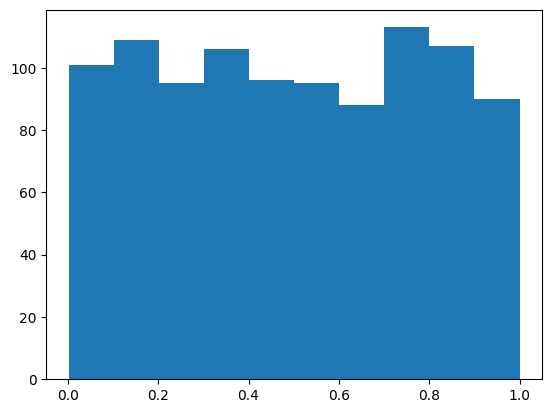

In [55]:
#Rysuje histogram dla x
plt.hist(x)
plt.show()

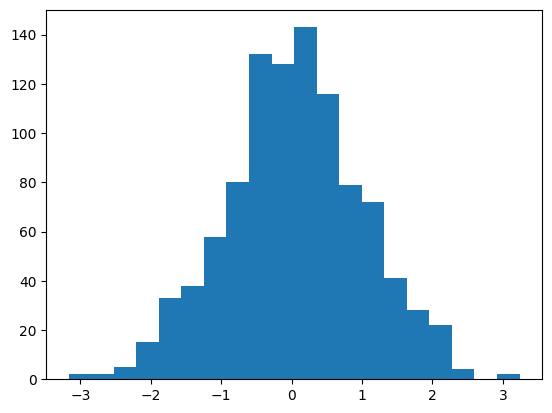

In [56]:
#Rysuje histogram dla y
plt.hist(y, bins = 20) #parametr bins - ile pudełek ma być widocznych na rysunku
plt.show()